# 📊 Analisis Data untuk Dashboard Aktivitas Sales

## 🎯 Tujuan Analisis
Notebook ini menganalisis data aktivitas sales untuk menghasilkan insight yang akan ditampilkan dalam dashboard interaktif. Tujuan utama:
1. Memantau dan mengevaluasi efektivitas aktivitas sales
2. Menghasilkan insight strategis dan operasional
3. Menyediakan dasar rekomendasi improvement yang data-driven

## 📝 Struktur Analisis
1. Import Library dan Data Preparation
2. Overview Aktivitas Sales (High-Level Metrics)
3. Sales Funnel Analysis
4. Analisis Durasi & Frekuensi Kunjungan
5. Performa Individu Sales
6. Detail Profil Sales
7. Analisis Segmentasi Customer
8. Insight & Rekomendasi Generator

## 💾 Output
Hasil analisis akan disimpan dalam format pickle untuk digunakan oleh dashboard Streamlit:
- overview_metrics.pkl
- funnel_analysis.pkl
- durasi_kunjungan.pkl
- performa_sales.pkl
- profil_sales.pkl
- segmentasi.pkl
- rekomendasi.pkl

## 1. Import Library dan Data Preparation

In [11]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle

# Set style plotting
sns.set_theme()  # Set seaborn theme
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]

# Baca dataset
df = pd.read_csv('sales_visits_finalbgt_enriched.csv')

# Konversi kolom tanggal
df['Tanggal'] = pd.to_datetime(df['Tanggal'])

In [12]:
# Cek kolom yang tersedia di dataset
print("Kolom yang tersedia dalam dataset:")
print(df.columns.tolist())

Kolom yang tersedia dalam dataset:
['ID_Kunjungan', 'ID_Customer', 'Tanggal', 'Nama_Sales', 'Level_Sales', 'Nilai_Kontrak', 'Target_Sales', 'Segmen', 'Target_Segmen', 'Jenis_Kunjungan', 'Nama_Customer', 'Status_Customer', 'Status_Kontrak', 'Catatan', 'Kunjungan_Ke', 'Progress']


## 2. Overview Aktivitas Sales (High-Level Metrics)

Bagian ini menganalisis metrik tingkat tinggi untuk memberikan gambaran umum aktivitas sales, meliputi:
- Total Customer Aktif
- Total Kunjungan
- Total Nilai Kontrak
- Status Deal/Potensi Deal
- Distribusi Segmen
- Jumlah Kunjungan per Tahap

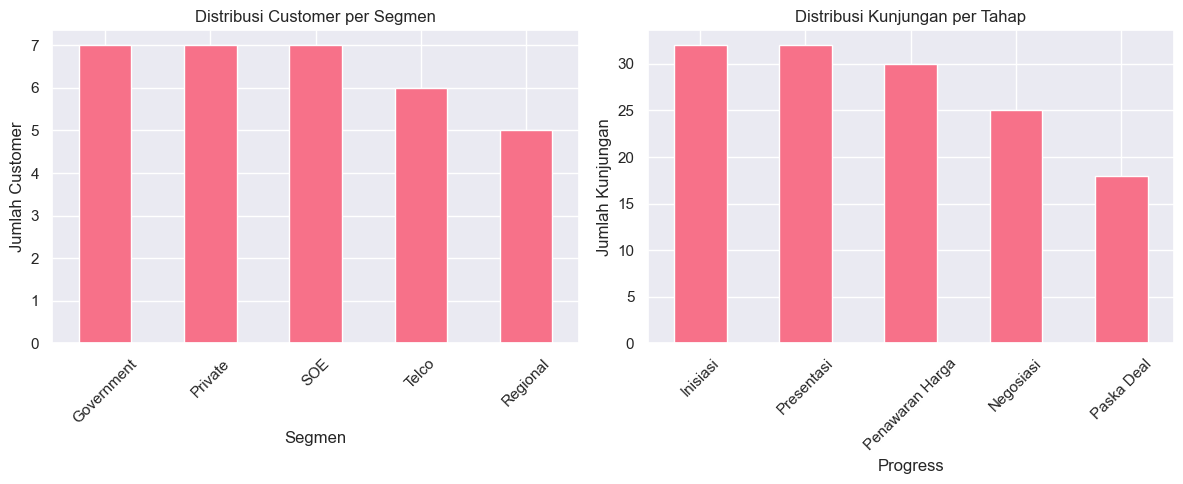


Ringkasan Metrik Tingkat Tinggi:
Total Customer Aktif: 32
Total Kunjungan: 137
Total Nilai Kontrak: Rp 14,177,000,000


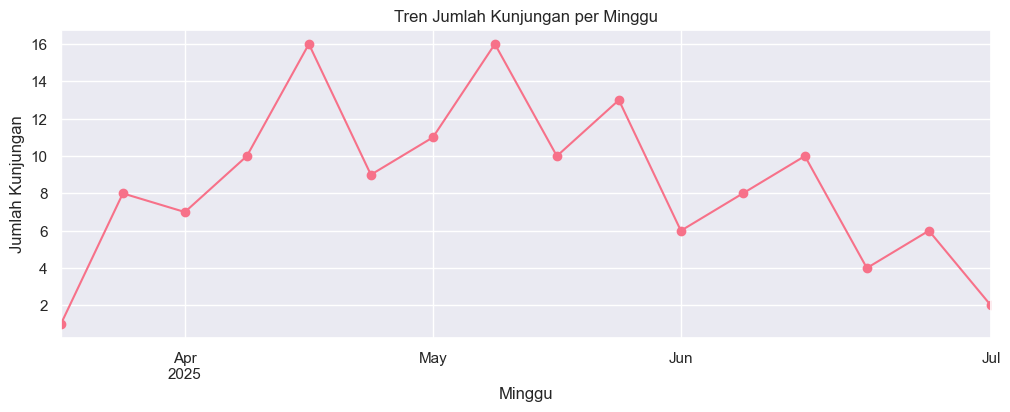

In [13]:
# Hitung metrik tingkat tinggi
overview_metrics = {
    'total_customer': df['ID_Customer'].nunique(),
    'total_kunjungan': len(df),
    'total_nilai_kontrak': df['Nilai_Kontrak'].sum()
}

# Analisis distribusi segmen
segment_dist = df.groupby('Segmen')['ID_Customer'].nunique().sort_values(ascending=False)

# Analisis kunjungan per tahap
tahap_dist = df.groupby('Progress')['ID_Customer'].count().reindex([
    'Inisiasi', 'Presentasi', 'Penawaran Harga', 'Negosiasi', 'Paska Deal'
])

# Visualisasi distribusi segmen
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
segment_dist.plot(kind='bar')
plt.title('Distribusi Customer per Segmen')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Customer')

# Visualisasi distribusi tahap
plt.subplot(1,2,2)
tahap_dist.plot(kind='bar')
plt.title('Distribusi Kunjungan per Tahap')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Kunjungan')
plt.tight_layout()
plt.show()

# Print ringkasan metrik
print("\nRingkasan Metrik Tingkat Tinggi:")
print(f"Total Customer Aktif: {overview_metrics['total_customer']:,}")
print(f"Total Kunjungan: {overview_metrics['total_kunjungan']:,}")
print(f"Total Nilai Kontrak: Rp {overview_metrics['total_nilai_kontrak']:,.0f}")

# Tren kunjungan per minggu
weekly_visits = df.groupby(pd.Grouper(key='Tanggal', freq='W'))['ID_Customer'].count()

plt.figure(figsize=(12,4))
weekly_visits.plot(kind='line', marker='o')
plt.title('Tren Jumlah Kunjungan per Minggu')
plt.xlabel('Minggu')
plt.ylabel('Jumlah Kunjungan')
plt.grid(True)
plt.show()

# Simpan hasil analisis
overview_data = {
    'metrics': overview_metrics,
    'segment_distribution': segment_dist,
    'tahap_distribution': tahap_dist,
    'weekly_trend': weekly_visits
}

with open('overview_metrics.pkl', 'wb') as f:
    pickle.dump(overview_data, f)

## 3. Sales Funnel Analysis

Analisis ini mengevaluasi efektivitas konversi di tiap tahap penjualan:
- Funnel chart dari Inisiasi ke Paska Deal
- Tingkat konversi antar tahap
- Analisis drop-off
- Perbandingan antar segmen dan sales

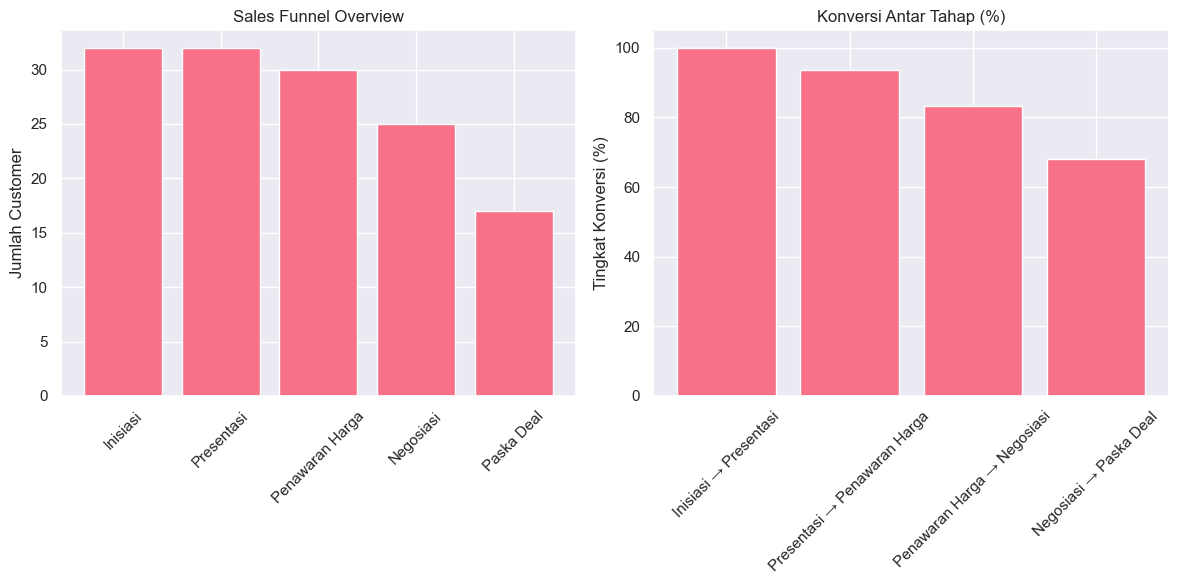

<Figure size 1500x500 with 0 Axes>

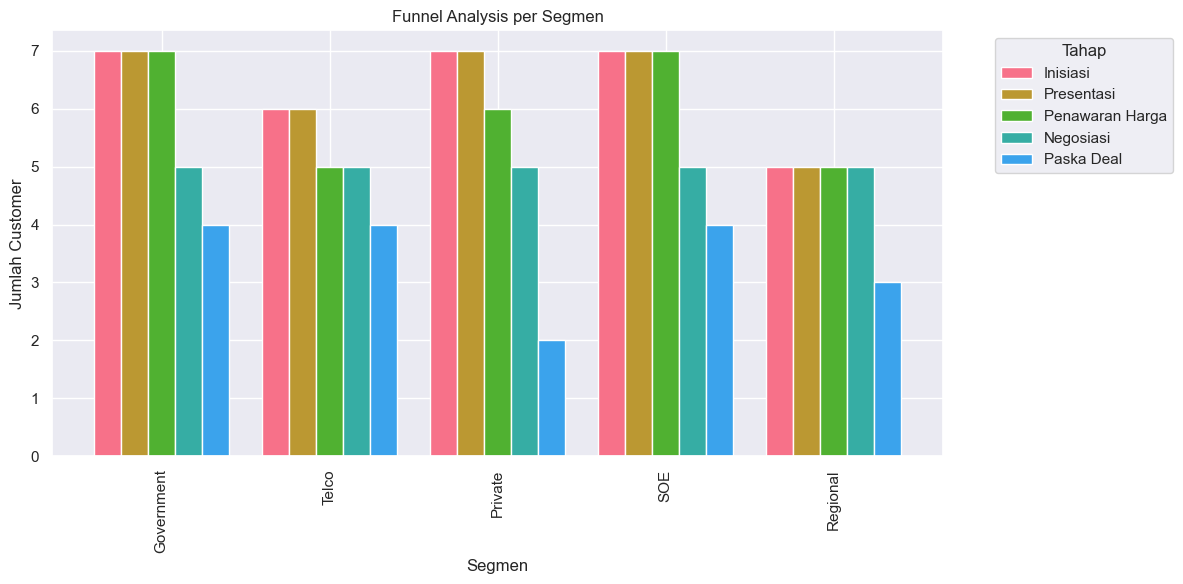


Tahap dengan drop-off terbesar: Negosiasi → Paska Deal
Jumlah customer yang drop: 8


In [14]:
# Definisikan urutan tahapan funnel
tahapan_funnel = ['Inisiasi', 'Presentasi', 'Penawaran Harga', 'Negosiasi', 'Paska Deal']

# Analisis funnel keseluruhan
funnel_overall = {}
for tahap in tahapan_funnel:
    funnel_overall[tahap] = df[df['Progress'] == tahap]['ID_Customer'].nunique()

# Hitung konversi antar tahap
konversi_tahap = {}
for i in range(len(tahapan_funnel)-1):
    tahap_current = tahapan_funnel[i]
    tahap_next = tahapan_funnel[i+1]
    if funnel_overall[tahap_current] > 0:
        konversi = (funnel_overall[tahap_next] / funnel_overall[tahap_current]) * 100
        konversi_tahap[f"{tahap_current} → {tahap_next}"] = konversi

# Visualisasi funnel
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.bar(funnel_overall.keys(), funnel_overall.values())
plt.title('Sales Funnel Overview')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Customer')

# Visualisasi konversi
plt.subplot(1,2,2)
plt.bar(konversi_tahap.keys(), konversi_tahap.values())
plt.title('Konversi Antar Tahap (%)')
plt.xticks(rotation=45)
plt.ylabel('Tingkat Konversi (%)')
plt.tight_layout()
plt.show()

# Analisis funnel per segmen
funnel_segmen = {}
for segmen in df['Segmen'].unique():
    df_segmen = df[df['Segmen'] == segmen]
    funnel_segmen[segmen] = {}
    for tahap in tahapan_funnel:
        funnel_segmen[segmen][tahap] = df_segmen[df_segmen['Progress'] == tahap]['ID_Customer'].nunique()

# Visualisasi funnel per segmen
plt.figure(figsize=(15,5))
segmen_df = pd.DataFrame(funnel_segmen).T
segmen_df.plot(kind='bar', width=0.8)
plt.title('Funnel Analysis per Segmen')
plt.xlabel('Segmen')
plt.ylabel('Jumlah Customer')
plt.legend(title='Tahap', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Identifikasi tahap dengan drop-off terbesar
drop_offs = {}
for i in range(len(tahapan_funnel)-1):
    tahap_current = tahapan_funnel[i]
    tahap_next = tahapan_funnel[i+1]
    drop = funnel_overall[tahap_current] - funnel_overall[tahap_next]
    drop_offs[f"{tahap_current} → {tahap_next}"] = drop

max_drop = max(drop_offs.items(), key=lambda x: x[1])
print(f"\nTahap dengan drop-off terbesar: {max_drop[0]}")
print(f"Jumlah customer yang drop: {max_drop[1]}")

# Simpan hasil analisis
funnel_data = {
    'funnel_overall': funnel_overall,
    'konversi_tahap': konversi_tahap,
    'funnel_segmen': funnel_segmen,
    'drop_offs': drop_offs
}

with open('funnel_analysis.pkl', 'wb') as f:
    pickle.dump(funnel_data, f)

## 4. Analisis Durasi & Frekuensi Kunjungan

Analisis ini mengukur kecepatan dan konsistensi proses penjualan:
- Rata-rata durasi dari Inisiasi ke Deal
- Rata-rata jeda antar kunjungan
- Distribusi waktu closing
- Korelasi antara frekuensi kunjungan dan keberhasilan closing

Rata-rata durasi mencapai Paska Deal: 74.8 hari
Median durasi mencapai Paska Deal: 74.0 hari

Rata-rata jeda antar kunjungan: 18.7 hari
Median jeda antar kunjungan: 18.0 hari


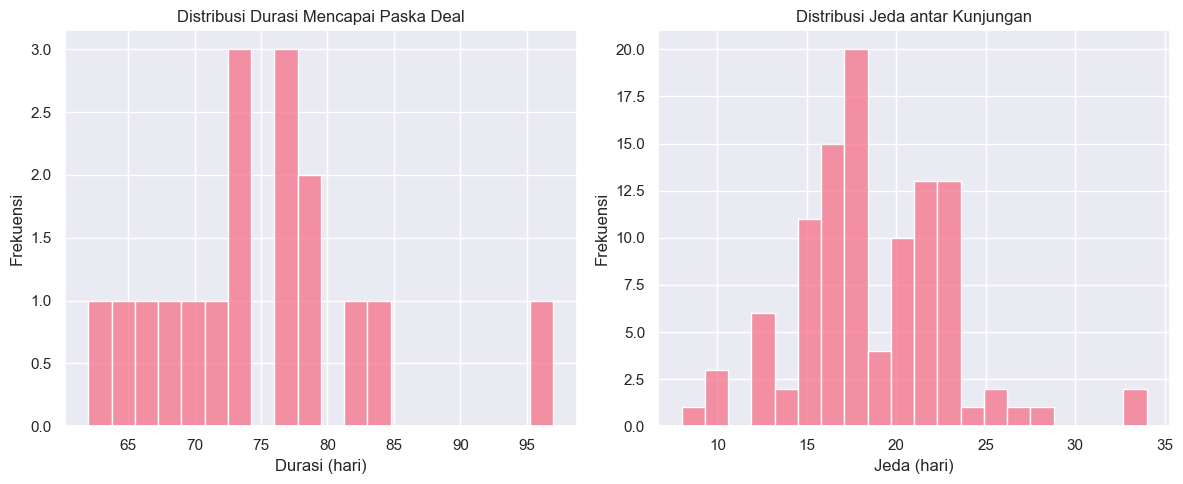

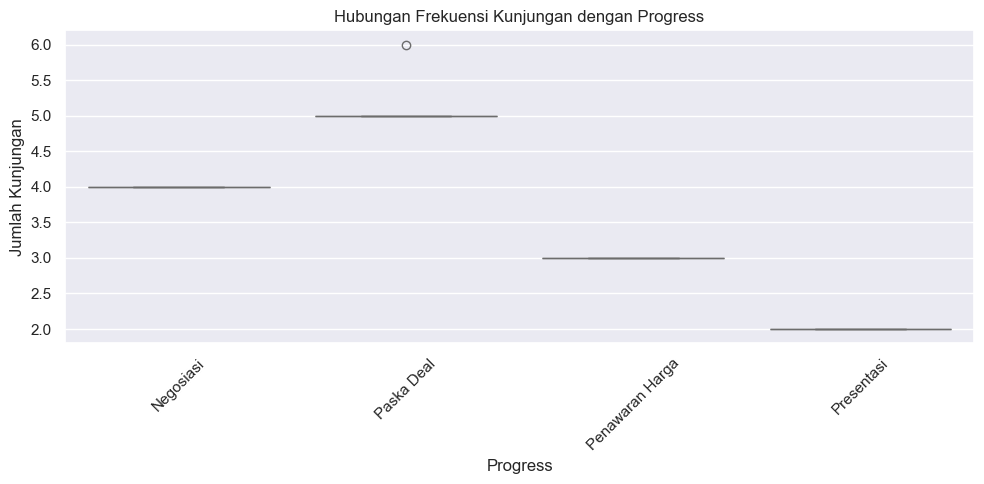


Jumlah customer yang perlu follow-up (>14 hari): 32


In [16]:
# Analisis durasi per customer
customer_duration = df.groupby('ID_Customer').agg({
    'Tanggal': lambda x: (x.max() - x.min()).days,
    'Progress': ['first', 'last']
}).reset_index()

customer_duration.columns = ['ID_Customer', 'Durasi_Total', 'Progress_Awal', 'Progress_Akhir']

# Hitung rata-rata durasi untuk customer yang mencapai Paska Deal
deal_duration = customer_duration[customer_duration['Progress_Akhir'] == 'Paska Deal']['Durasi_Total']
print(f"Rata-rata durasi mencapai Paska Deal: {deal_duration.mean():.1f} hari")
print(f"Median durasi mencapai Paska Deal: {deal_duration.median():.1f} hari")

# Analisis jeda antar kunjungan
customer_gaps = []
for customer in df['ID_Customer'].unique():
    visits = df[df['ID_Customer'] == customer]['Tanggal'].sort_values()
    if len(visits) > 1:
        gaps = visits.diff().dt.days.dropna()
        customer_gaps.extend(gaps)

avg_gap = np.mean(customer_gaps)
median_gap = np.median(customer_gaps)
print(f"\nRata-rata jeda antar kunjungan: {avg_gap:.1f} hari")
print(f"Median jeda antar kunjungan: {median_gap:.1f} hari")

# Visualisasi distribusi durasi
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(deal_duration, bins=20)
plt.title('Distribusi Durasi Mencapai Paska Deal')
plt.xlabel('Durasi (hari)')
plt.ylabel('Frekuensi')

# Visualisasi distribusi jeda kunjungan
plt.subplot(1,2,2)
sns.histplot(customer_gaps, bins=20)
plt.title('Distribusi Jeda antar Kunjungan')
plt.xlabel('Jeda (hari)')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# Analisis hubungan frekuensi kunjungan dengan progress
customer_freq = df.groupby('ID_Customer').agg({
    'Tanggal': 'count',
    'Progress': 'last'
}).rename(columns={'Tanggal': 'Jumlah_Kunjungan'})

plt.figure(figsize=(10,5))
sns.boxplot(data=customer_freq, x='Progress', y='Jumlah_Kunjungan')
plt.title('Hubungan Frekuensi Kunjungan dengan Progress')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Kunjungan')
plt.tight_layout()
plt.show()

# Identifikasi customer yang perlu follow-up (tidak dikunjungi > 14 hari)
last_visit = df.groupby('ID_Customer')['Tanggal'].max()
days_since_visit = (pd.Timestamp.now() - last_visit).dt.days
needs_followup = days_since_visit[days_since_visit > 14]

print(f"\nJumlah customer yang perlu follow-up (>14 hari): {len(needs_followup)}")

# Simpan hasil analisis
duration_data = {
    'customer_duration': customer_duration,
    'deal_duration_stats': {
        'mean': deal_duration.mean(),
        'median': deal_duration.median()
    },
    'visit_gaps': {
        'mean': avg_gap,
        'median': median_gap
    },
    'customer_freq': customer_freq,
    'needs_followup': needs_followup
}

with open('durasi_kunjungan.pkl', 'wb') as f:
    pickle.dump(duration_data, f)

## 5. Performa Individu Sales

Analisis performa individual untuk setiap sales:
- Total kunjungan dan nilai kontrak
- Tingkat konversi dan closing rate
- Rata-rata progress customer
- Efektivitas aktivitas sales

Leaderboard Sales berdasarkan Jumlah Deal:
                Jumlah_Deal  Total_Nilai_Kontrak  Closing_Rate  Efektivitas
Nama_Sales                                                                 
Agus Darmawan           3.0           1730000000        100.00        20.00
Nina Anggraini          3.0            655000000        100.00        20.00
Budi Santoso            2.0           1610000000         50.00        11.11
Dian Permata            2.0           1412000000         66.67        13.33
Rudi Hartono            2.0            732000000         66.67        14.29
Siti Rahayu             2.0           3009000000         50.00        11.76
Ahmad Fauzi             1.0           1163000000         33.33         9.09
Hendra Wijaya           1.0           1170000000         33.33         9.09
Maya Susanti            1.0           1537000000         33.33         9.09
Dewi Pratiwi            NaN           1159000000          0.00         0.00


C:\Users\SITI NURAFIFA(RIMA)\AppData\Local\Temp\ipykernel_4504\2521573139.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(sales, (sales_performance['Total_Kunjungan'][i], sales_performance['Jumlah_Deal'][i]))


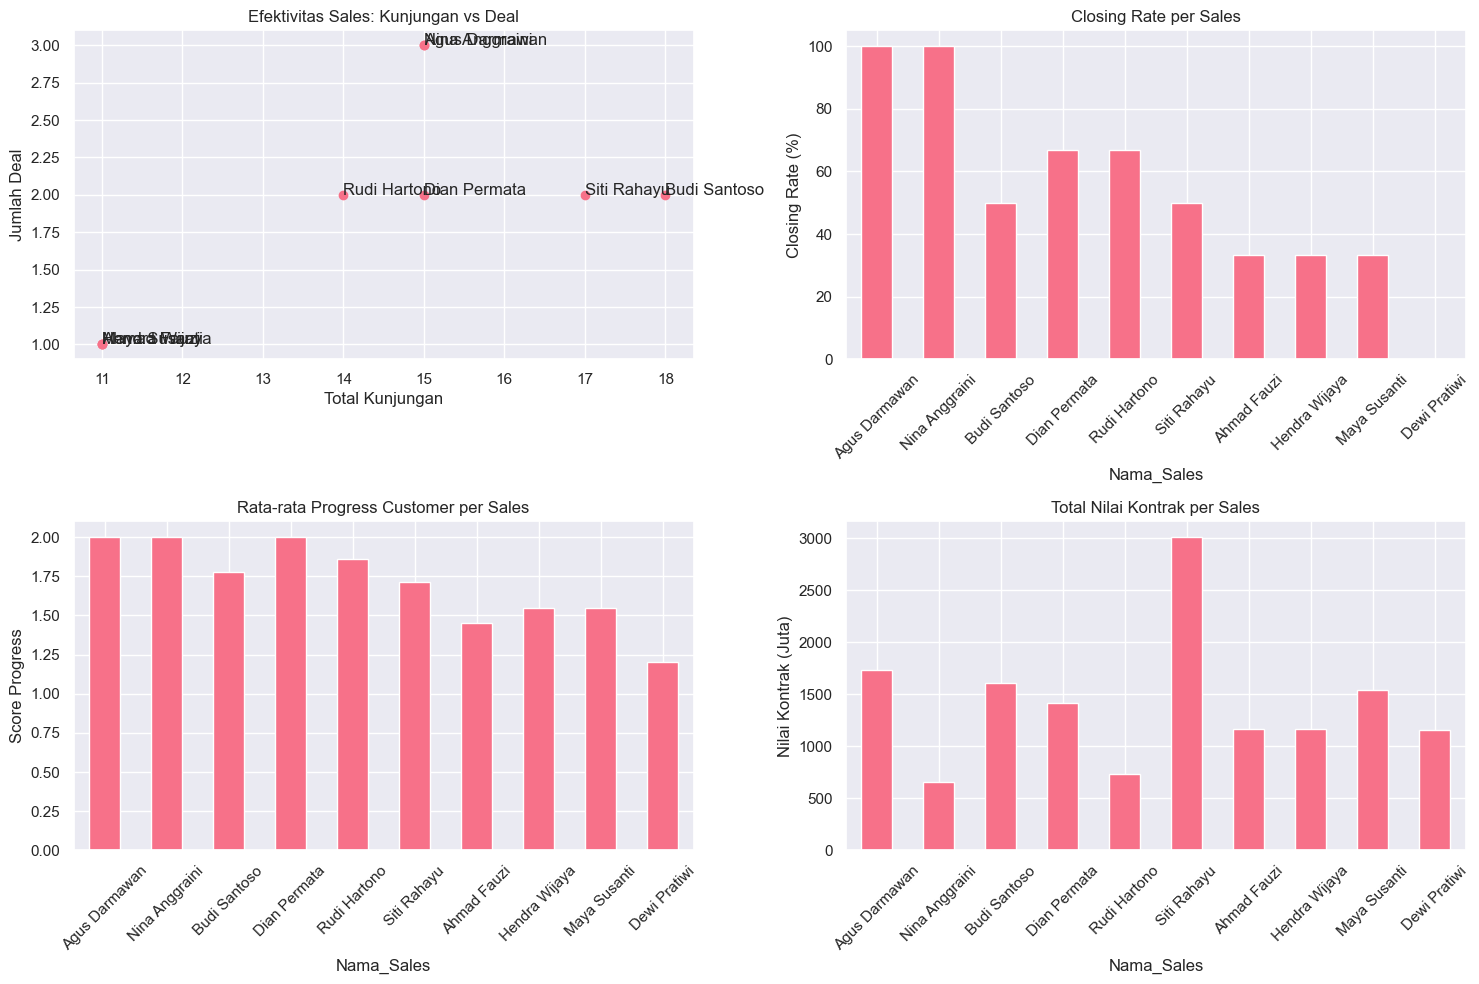

In [ ]:
# Analisis kinerja per sales
sales_performance = df.groupby('Nama_Sales').agg(
    Total_Kunjungan=('ID_Customer', 'count'),
    Total_Nilai_Kontrak=('Nilai_Kontrak', 'sum'),
    Jumlah_Customer=('ID_Customer', 'nunique')
)

# Hitung jumlah deals per sales (customer yang mencapai Paska Deal)
deals_per_sales = df[df['Progress'] == 'Paska Deal'].groupby('Nama_Sales')['ID_Customer'].nunique()
sales_performance['Jumlah_Deal'] = deals_per_sales.fillna(0).astype(int)

# Hitung closing rate
sales_performance['Closing_Rate'] = (sales_performance['Jumlah_Deal'] / sales_performance['Jumlah_Customer'] * 100).fillna(0).round(2)
# Analisis progress customer per sales
progress_mapping = {tahap: idx for idx, tahap in enumerate(tahapan_funnel)}
df['Progress_Score'] = df['Progress'].map(progress_mapping)

avg_progress = df.groupby('Nama_Sales')['Progress_Score'].mean().round(2)
sales_performance['Rata_Rata_Progress'] = avg_progress.fillna(0)

# Hitung efektivitas (Deal per Kunjungan)
sales_performance['Efektivitas'] = (sales_performance['Jumlah_Deal'] / sales_performance['Total_Kunjungan'] * 100).fillna(0).round(2)
# Sort berdasarkan jumlah deal
sales_performance = sales_performance.sort_values('Jumlah_Deal', ascending=False)

# Print leaderboard
print("Leaderboard Sales berdasarkan Jumlah Deal:")
print(sales_performance[['Jumlah_Deal', 'Total_Nilai_Kontrak', 'Closing_Rate', 'Efektivitas']])

# Visualisasi performa
plt.figure(figsize=(15, 10))

# Plot 1: Total Kunjungan vs Jumlah Deal
plt.subplot(2, 2, 1)
plt.scatter(sales_performance['Total_Kunjungan'], sales_performance['Jumlah_Deal'])
for i, sales in enumerate(sales_performance.index):
    plt.annotate(sales, (sales_performance['Total_Kunjungan'][i], sales_performance['Jumlah_Deal'][i]))
plt.xlabel('Total Kunjungan')
plt.ylabel('Jumlah Deal')
plt.title('Efektivitas Sales: Kunjungan vs Deal')

# Plot 2: Closing Rate per Sales
plt.subplot(2, 2, 2)
sales_performance['Closing_Rate'].plot(kind='bar')
plt.title('Closing Rate per Sales')
plt.xticks(rotation=45)
plt.ylabel('Closing Rate (%)')

# Plot 3: Rata-rata Progress per Sales
plt.subplot(2, 2, 3)
sales_performance['Rata_Rata_Progress'].plot(kind='bar')
plt.title('Rata-rata Progress Customer per Sales')
plt.xticks(rotation=45)
plt.ylabel('Score Progress')

# Plot 4: Total Nilai Kontrak per Sales
plt.subplot(2, 2, 4)
(sales_performance['Total_Nilai_Kontrak'] / 1e6).plot(kind='bar')  # Dalam jutaan
plt.title('Total Nilai Kontrak per Sales')
plt.xticks(rotation=45)
plt.ylabel('Nilai Kontrak (Juta)')

plt.tight_layout()
plt.show()

# Identifikasi sales yang perlu pendampingan
low_performers = sales_performance[
    (sales_performance['Closing_Rate'] < sales_performance['Closing_Rate'].median()) & 
    (sales_performance['Total_Kunjungan'] > sales_performance['Total_Kunjungan'].median())
]

if len(low_performers) > 0:
    print("\nSales yang memerlukan pendampingan (aktivitas tinggi, konversi rendah):")
    print(low_performers[['Total_Kunjungan', 'Closing_Rate']])

# Simpan hasil analisis
performa_data = {
    'sales_performance': sales_performance,
    'low_performers': low_performers,
    'top_performer': sales_performance.index[0]  # Sales dengan deal tertinggi
}

with open('performa_sales.pkl', 'wb') as f:
    pickle.dump(performa_data, f)

## 6. Detail Profil Sales

Analisis mendalam untuk setiap sales meliputi:
- Timeline dan pola kunjungan
- Distribusi jenis aktivitas
- Pencapaian tahapan tertinggi
- Catatan kunjungan yang efektif

In [ ]:
# Fungsi untuk menganalisis profil individual sales
def analyze_sales_profile(sales_name):
    sales_data = df[df['Nama_Sales'] == sales_name]
    
    # Timeline kunjungan
    visits_timeline = sales_data.groupby('Tanggal').size()
    
    # Distribusi jenis kunjungan
    visit_types = sales_data['Progress'].value_counts()
    
    # Tahap tertinggi per customer
    highest_progress = sales_data.groupby('ID_Customer')['Progress_Score'].max()
    avg_highest_progress = highest_progress.mean()
    
    # Analisis catatan kunjungan
    common_notes = sales_data.groupby('Catatan_Kunjungan').agg({
        'ID_Customer': 'count',
        'Progress_Score': 'max'
    }).sort_values('ID_Customer', ascending=False).head()
    
    return {
        'timeline': visits_timeline,
        'visit_types': visit_types,
        'avg_highest_progress': avg_highest_progress,
        'common_notes': common_notes
    }

# Analisis semua sales
sales_profiles = {}
for sales in df['Nama_Sales'].unique():
    sales_profiles[sales] = analyze_sales_profile(sales)

# Contoh visualisasi untuk sales teratas
top_sales = sales_performance.index[0]
top_profile = sales_profiles[top_sales]

plt.figure(figsize=(15, 10))

# Plot 1: Timeline kunjungan
plt.subplot(2, 2, 1)
top_profile['timeline'].plot()
plt.title(f'Timeline Kunjungan - {top_sales}')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Kunjungan')

# Plot 2: Distribusi jenis kunjungan
plt.subplot(2, 2, 2)
top_profile['visit_types'].plot(kind='bar')
plt.title('Distribusi Jenis Kunjungan')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Kunjungan')

# Plot 3: Pola progress funnel
success_pattern = df[
    (df['Nama_Sales'] == top_sales) & 
    (df['Progress'] == 'Paska Deal')
].groupby('Progress')['ID_Customer'].count()

plt.subplot(2, 2, 3)
success_pattern.plot(kind='bar')
plt.title('Pola Progress Funnel untuk Deal')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Customer')

# Plot 4: Efektivitas catatan kunjungan (berdasarkan Progress Score)
plt.subplot(2, 2, 4)
effective_notes = top_profile['common_notes']['Progress_Score'] / top_profile['common_notes']['ID_Customer'] * 100
effective_notes.plot(kind='bar')
plt.title('Efektivitas Catatan Kunjungan')
plt.xticks(rotation=45)
plt.ylabel('Progress Score Rate (%)')

plt.tight_layout()
plt.show()

# Identifikasi best practices
print(f"\nBest Practices dari {top_sales}:")
print("1. Pola Kunjungan Efektif:")
print(f"   - Rata-rata progress tertinggi: {top_profile['avg_highest_progress']:.2f}")
print("\n2. Catatan Kunjungan yang Efektif:")
print(top_profile['common_notes'])

# Simpan hasil analisis
profil_data = {
    'sales_profiles': sales_profiles,
    'top_sales_profile': {
        'name': top_sales,
        'profile': top_profile
    }
}

with open('profil_sales.pkl', 'wb') as f:
    pickle.dump(profil_data, f)

## 7. Insight & Rekomendasi Otomatis

Menghasilkan insight strategis dan rekomendasi otomatis berdasarkan analisis data:
- Highlight kinerja sales
- Identifikasi bottleneck
- Rekomendasi tindakan
- To-do list prioritas

In [ ]:
# Generate automated insights dan rekomendasi
insights = []
recommendations = []

# 1. Analisis Kinerja Sales
top_performer = sales_performance.index[0]
insights.append(f"🏆 Top Performer: {top_performer}")
insights.append(f"   - {sales_performance.loc[top_performer, 'Jumlah_Deal']} deals")
insights.append(f"   - Closing rate {sales_performance.loc[top_performer, 'Closing_Rate']}%")

if len(low_performers) > 0:
    insights.append(f"\n⚠️ {len(low_performers)} sales memerlukan pendampingan")
    recommendations.append("📋 Jadwalkan sesi mentoring dengan top performer")

# 2. Analisis Bottleneck
max_drop_phase = max(drop_offs.items(), key=lambda x: x[1])
insights.append(f"\n🔍 Bottleneck teridentifikasi pada tahap {max_drop_phase[0]}")
insights.append(f"   - {max_drop_phase[1]} customer tidak melanjutkan ke tahap berikutnya")

if 'Penawaran Harga' in max_drop_phase[0]:
    recommendations.append("💡 Review strategi pricing dan negosiasi")
elif 'Presentasi' in max_drop_phase[0]:
    recommendations.append("💡 Evaluasi materi presentasi dan teknik komunikasi")

# 3. Analisis Follow-up
if len(needs_followup) > 0:
    insights.append(f"\n⏰ {len(needs_followup)} customer memerlukan follow-up segera")
    recommendations.append("📱 Prioritaskan follow-up customer yang tidak dikunjungi > 14 hari")

# 4. Analisis Segmen
best_segment = segment_dist.index[0]
worst_segment = segment_dist.index[-1]
insights.append(f"\n📊 Segmen terbesar: {best_segment} ({segment_dist[best_segment]} customer)")
insights.append(f"📉 Segmen terkecil: {worst_segment} ({segment_dist[worst_segment]} customer)")

if segment_dist[worst_segment] < segment_dist[best_segment] * 0.3:
    recommendations.append(f"🎯 Tingkatkan fokus pada segmen {worst_segment}")

# 5. Analisis Durasi
if deal_duration.mean() > 60:  # Jika rata-rata > 2 bulan
    insights.append(f"\n⏳ Rata-rata waktu closing ({deal_duration.mean():.1f} hari) terlalu lama")
    recommendations.append("⚡ Identifikasi cara mempercepat proses closing")

# 6. To-do List Prioritas
todo_list = [
    f"1. Follow-up {len(needs_followup)} customer yang belum dikunjungi > 14 hari",
    f"2. Analisis penyebab drop-off di tahap {max_drop_phase[0]}",
    f"3. Jadwalkan mentoring {len(low_performers)} sales dengan {top_performer}",
    "4. Review target per segmen dan strategi pendekatan",
    "5. Evaluasi durasi proses penjualan"
]

# Print hasil
print("🔍 INSIGHTS UTAMA:")
print("-----------------")
for insight in insights:
    print(insight)

print("\n📋 REKOMENDASI:")
print("--------------")
for rec in recommendations:
    print(rec)

print("\n✅ TO-DO LIST PRIORITAS:")
print("---------------------")
for todo in todo_list:
    print(todo)

# Simpan hasil analisis
rekomendasi_data = {
    'insights': insights,
    'recommendations': recommendations,
    'todo_list': todo_list
}

with open('rekomendasi.pkl', 'wb') as f:
    pickle.dump(rekomendasi_data, f)